Implementation of stochastic and batch grandient descent in python

#### We use home prices data set to implement batch and stochastic gradient descent.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Load the dataset in pandas dataframe

In [2]:
df = pd.read_csv("homeprices_banglore.csv")
df.sample(5)

,area,bedrooms,price
12,1000,2,38.00
9,3700,5,167.00
6,2732,4,135.00
19,800,1,32.00
0,1056,2,39.07


#### Preprocessing/Scaling: Since our columns are on different sacle it is important to perform scaling on them

In [3]:
from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(df.drop('price',axis='columns'))
scaled_y = sy.fit_transform(df['price'].values.reshape(df.shape[0],1))

scaled_X

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ],
       [0.12758621, 0.25      ],
       [0.6662069 , 0.75      ],
       [0.86206897, 0.75      ],
       [0.17586207, 0.5       ],
       [1.        , 1.        ],
       [0.34482759, 0.5       ],
       [0.68448276, 0.75      ],
       [0.06896552, 0.25      ],
       [0.10344828, 0.25      ],
       [0.5       , 0.5       ],
       [0.12931034, 0.25      ],
       [0.13103448, 0.5       ],
       [0.25517241, 0.5       ],
       [0.67931034, 0.5       ],
       [0.        , 0.        ]])

In [4]:
scaled_y

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074],
       [0.04444444],
       [0.76296296],
       [0.91111111],
       [0.13333333],
       [1.        ],
       [0.37037037],
       [0.8       ],
       [0.04444444],
       [0.05925926],
       [0.51111111],
       [0.07407407],
       [0.11851852],
       [0.20740741],
       [0.51851852],
       [0.        ]])

##### We should convert target column (i.e. price) into one dimensional array. It has become 2D due to scaling that we did above but now we should change to 1D

In [5]:
scaled_y.reshape(20,)

array([0.05237037, 0.65185185, 0.22222222, 0.31851852, 0.14074074,
       0.04444444, 0.76296296, 0.91111111, 0.13333333, 1.        ,
       0.37037037, 0.8       , 0.04444444, 0.05925926, 0.51111111,
       0.07407407, 0.11851852, 0.20740741, 0.51851852, 0.        ])

##### Gradient descent allows you to find weights (w1,w2,w3) and bias in following linear equation for housing price prediction

## Batch gradient descent. 

In [23]:
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):

    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 2 (area, bedroom)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):        
        y_predicted = np.dot(w, X.T) + b

        w_grad = -(2/total_samples)*(X.T.dot(y_true-y_predicted))
        b_grad = -(2/total_samples)*np.sum(y_true-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),1000)
w, b, cost

(array([0.66469087, 0.60541671]), -0.17792104056392882, 0.0048654808183488454)

###### Check price equation above. In that equation we were trying to find values of w1,w2 and bias. Here we got these values for each of them,
w1 = 0.66469087
w2 = 0.60541671
bias = -0.17792104056392882

###### Now plot epoch vs cost graph to see how cost reduces as number of epoch increases

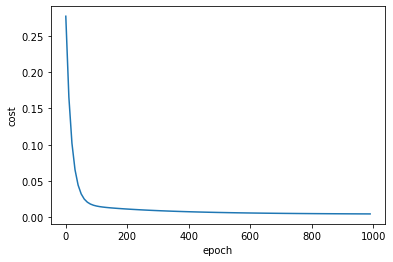

In [24]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)

###### Lets do some predictions now. 

In [25]:
def predict(area,bedrooms,w,b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    # here w1 = w[0] , w2 = w[1], w3 = w[2] and bias is b
    # equation for price is w1*area + w2*bedrooms + w3*age + bias
    # scaled_X[0] is area
    # scaled_X[1] is bedrooms
    # scaled_X[2] is age
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    # once we get price prediction we need to to rescal it back to original value
    # also since it returns 2D array, to get single value we need to do value[0][0]
    return sy.inverse_transform([[scaled_price]])[0][0]

predict(2600,4,w,b)

124.97561189905038

In [26]:
predict(1000,2,w,b)

34.60197457980031

In [27]:
predict(1500,3,w,b)

70.50604143757819

## Stochastic Gradient Descent Implementation

#### Stochastic GD will use randomly picked single training sample to calculate error and using this error we backpropage to adjust weights

In [13]:
# we will use random libary to pick random training sample.
import random
random.randint(0,6) # randit gives random number between two numbers specified in the argument

4

In [31]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
 
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):    
        random_index = random.randint(0,total_samples-1) # random index from total samples
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
    
        w_grad = -(2/total_samples)*(sample_x.T.dot(sample_y-y_predicted))
        b_grad = -(2/total_samples)*(sample_y-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.square(sample_y-y_predicted)
        
        if i%100==0: # at every 100th iteration record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),20000)
w_sgd, b_sgd, cost_sgd

(array([0.66130929, 0.6033146 ]), -0.17936819370716411, 0.0005087915769580153)

Compare this with weights and bias that we got using gradient descent. They both of quite similar.

In [32]:
w , b 

(array([0.66469087, 0.60541671]), -0.17792104056392882)

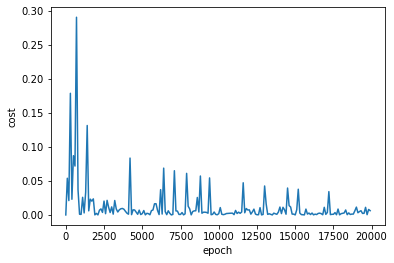

In [33]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list_sgd,cost_list_sgd)

In [34]:
predict(2600,4,w_sgd, b_sgd) 

124.28405447281894

In [35]:
predict(1000,2,w_sgd, b_sgd)

34.304179082893924

In [36]:
predict(1500,3,w_sgd, b_sgd)

70.05859054705573

### Exercise

#### Implement mini batch gradient descent in python and plot cost vs epoch graph. Mini batch is intermediate version of batch GD and stochastic GD. In stochastic we used one randomly picked training sample, In mini gradient descent you will use a batch of samples in each iterations. For example if you have total 50 training samples, you can take a batch of 10 samples, calculate cumulitive error for those 10 samples and then adjust weights. In SGD we adjust weights after every one sample. In Batch we adjust weights after going through all samples but in mini batch we do after every m samples (where m is batch size and it is 0 < m < n, where n is total number of samples



In [ ]:
def mini_batch_gradient_descent(X, y_true, epochs = 100, batch_size = 5, learning_rate = 0.01):
    
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    if batch_size > total_samples: # In this case mini batch becomes same as batch gradient descent
        batch_size = total_samples
        
    cost_list = []
    epoch_list = []
    
    num_batches = int(total_samples/batch_size)
    
    for i in range(epochs):    
        random_indices = np.random.permutation(total_samples)
        X_tmp = X[random_indices]
        y_tmp = y_true[random_indices]
        
        for j in range(0,total_samples,batch_size):
            Xj = X_tmp[j:j+batch_size]
            yj = y_tmp[j:j+batch_size]
            y_predicted = np.dot(w, Xj.T) + b
            
            w_grad = -(2/len(Xj))*(Xj.T.dot(yj-y_predicted))
            b_grad = -(2/len(Xj))*np.sum(yj-y_predicted)
            
            w = w - learning_rate * w_grad
            b = b - learning_rate * b_grad
                
            cost = np.mean(np.square(yj-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = mini_batch_gradient_descent(
    scaled_X,
    scaled_y.reshape(scaled_y.shape[0],),
    epochs = 120,
    batch_size = 5
)
w, b, cost